Será abordado a otimização de **hiperparametros** utilizando a base de dados de preços de carros.

Esses parametros são passados ao algoritmo antes do treinamento, esses parametros são chamados de **Hiperparametros**.

In [37]:
import pandas as pd

df = pd.read_csv('preco_carros_modificado.csv')
df.head()

,preco,vendido,km_por_ano,idade_carro,modelo_carro
0,30941.02,1,35085.308544,24,22
1,40557.96,1,12622.084992,26,28
2,89627.50,0,11440.826496,18,18
3,95276.14,0,43167.434112,9,10
4,117384.68,1,12770.144640,10,9


In [38]:
X = df.drop('vendido', axis=1)
y = df['vendido']

In [39]:
def imprime_resultados(results):
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()
    media_treino = results['train_score'].mean()

    print(f'Acurácia média treino: {media_treino*100:.2f}%')
    print(f'Acurácia média teste: {media*100:.2f}%')
    print(f'Acurácia com validação cruzada: {(media - 2 * desvio_padrao)*100:.2f}% // {(media + 2 * desvio_padrao)*100:.2f}%')

### Treinando o modelo com Pipeline e Plot da Árvore de Decisão

Acurácia média treino: 78.75%
Acurácia média teste: 78.69%
Acurácia com validação cruzada: 77.15% // 80.23%


[Text(0.4230769230769231, 0.875, 'preco <= -0.192\ngini = 0.487\nsamples = 10000\nvalue = [4200, 5800]\nclass = sim'),
 Text(0.15384615384615385, 0.625, 'preco <= -0.981\ngini = 0.198\nsamples = 4347\nvalue = [484, 3863]\nclass = sim'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 1935\nvalue = [0, 1935]\nclass = sim'),
 Text(0.23076923076923078, 0.375, 'preco <= -0.941\ngini = 0.321\nsamples = 2412\nvalue = [484, 1928]\nclass = sim'),
 Text(0.15384615384615385, 0.125, 'gini = 0.434\nsamples = 110\nvalue = [35, 75]\nclass = sim'),
 Text(0.3076923076923077, 0.125, 'gini = 0.314\nsamples = 2302\nvalue = [449, 1853]\nclass = sim'),
 Text(0.6923076923076923, 0.625, 'km_por_ano <= 0.161\ngini = 0.45\nsamples = 5653\nvalue = [3716.0, 1937.0]\nclass = não'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.375, 'preco <= 1.391\ngini = 0.498\nsamples = 3513\nvalue = [1879.0, 1634.0]\nclass = não'),
 Text(0.461538461

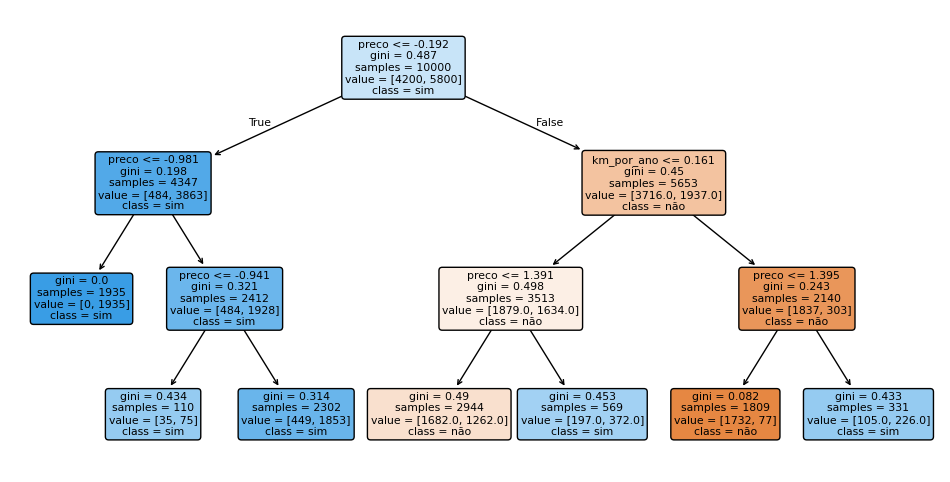

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_validate, GroupKFold, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(SEED)

scaler = StandardScaler()
dt_model = DecisionTreeClassifier(max_depth=3)

kfold = StratifiedKFold(n_splits=10)
pipeline = Pipeline([
    ('preprocessing', scaler),
    ('estimator', dt_model)
])

results = cross_validate(pipeline, X, y, cv=kfold, return_train_score=True)
imprime_resultados(results)

pipeline.fit(X, y)

plt.figure(figsize=(12,6))
plot_tree(dt_model,
          filled=True,
          rounded=True,
          feature_names=X.columns, # Ao invés dos índices das colunas, aparecerá os nomes de cada coluna
          class_names=['não', 'sim'])

### Quanto mais complexa a árvore, melhor?

No cenário de modelos de árvore de decisão, árvores com apenas 1 profundidade (max_depth = 1) talvez não seja suficiente, porém o contrário, ou seja, muitas profundidades na árvore, consequentemente fará com que a árvore de decisão fique mais complexa, mas não necessariamente seja mais precisa, então é necessário achar um valor equilibrado.

Na verdade, caso a árvore for muito complexa (muitas profundidades, max_depth=32, por exemplo), pode ocorrer o **Overfit**, que é quando o modelo se ajusta muito bem aos dados de **treino**, porém não generaliza bem para os novos dados, em outras palavras, na etapa de testes onde o modelo se encontra com dados que nunca viu, não se sai muito bem, pois apenas **"decorou"** os dados de treino (como por exemplo, decorou o conteúdo para a prova, mas não aprendeu).

Podemos exemplificar abaixo um caso de **Overfitting**:

In [41]:
def arvore_decisao(max_depth):
    kfold = StratifiedKFold(n_splits=10)
    dt_model = DecisionTreeClassifier(max_depth=max_depth)

    results = cross_validate(dt_model, X, y, cv=kfold, return_train_score=True)
    return [max_depth, results['train_score'].mean(), results['test_score'].mean()]

# Cria árvores de decisão de 2 até 32 de profundidade (max_depth)
results = [arvore_decisao(i) for i in range (1,32)]

df_results = pd.DataFrame(results, columns=['max_depth', 'train', 'test'])
df_results.head()

,max_depth,train,test
0,1,0.757911,0.7578
1,2,0.757911,0.7578
2,3,0.787533,0.7869
3,4,0.788167,0.7847
4,5,0.790000,0.7851


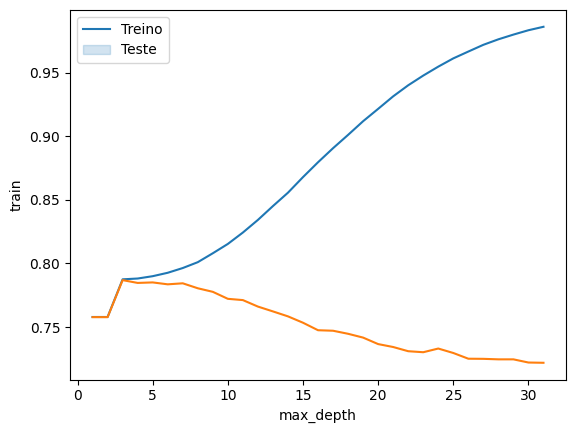

In [42]:
import seaborn as sns

sns.lineplot(data=df_results, x='max_depth', y='train')
sns.lineplot(data=df_results, x='max_depth', y='test')
plt.legend(['Treino','Teste'])

É possível perceber que a medida que aumenta o número de *max_depth*, a linha de treino em *azul* aumenta, porém a linha de *teste* em *laranja* desce.

Isso significa que o nosso modelo é muito bom para os dados de treino, porém muito mal para os dados de teste, isso se chama **Overfit**

In [43]:
# O melhor parametro de max_depth estará em primeiro na lista
df_results.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,0.787533,0.7869
4,5,0.790000,0.7851
3,4,0.788167,0.7847
6,7,0.796411,0.7844
5,6,0.792689,0.7836


### Alguns Hiperparametros da Árvore de Decisão
**min_samples_leaf**
- Este parametro define a quantidade de exemplos mínimos (samples/dados) necessários para aquele nó de decisão.

**min_samples_split**
- É o número mínimo de exemplos para dividir o nó.

Veja mais na documentação do Scikit-Learn:
- https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Busca de Hiperparametros com **GridSearchCV** (CV = Cross Validation) e **Escolha do melhor modelo**

Explorando espaços de hiperparâmetros com GridSearchCV com Cross Validation.

- O Algoritmo GridSearchCV rodará o Cross Validation dentro dele, por isso, devemos passar qual o tipo do "CV", assim como, passar os dados.

**Quais são os resultados do GridSerarCV?**
- O Resultado do GridSearchCV pode ser acessado pela propriedade *cv_results_*.
- Os melhores parâmetros pela propriedade *best_params_*.
- E o melhor modelo pela propriedade *best_estimator_*.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Configurando o espaço de hiperparametros
parametros = {
    'max_depth': [3,5],
    'min_samples_split': [32,64,128],
    'min_samples_leaf': [32,64,128],
    'criterion': ['gini', 'entropy']
}

# Definindo qual será o modelo, no caso Árvore de Decisão
model_dt = DecisionTreeClassifier()

# Definindo o tipo da validação cruzada (no caso, KFold Estratificado)
cv = StratifiedKFold(n_splits=10)

# Algoritmo de busca de parametros
search = GridSearchCV(model_dt, 
                      parametros, 
                      cv=cv, 
                      n_jobs=-1) # Paraleliza o processo para todas as cores do processador

# Treinar o algoritmo de busca (funciona como um modelo de ML)
search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5],
                         'min_samples_leaf': [32, 64, 128],
                         'min_samples_split': [32, 64, 128]})

In [45]:
# Os melhores parametros buscados pelo algorítimo
search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [46]:
# O melhor modelo (já treinado)
search.best_estimator_

best_estimator = search.best_estimator_
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Já que temos o nosso melhor modelo escolhido, agora iremos realizar um teste para verificar sua acurácia.

In [47]:
from sklearn.metrics import accuracy_score

# Evitar essa abordagem pois eataremos sendo muito otimistas
# Pois não queremos viciar nosso modelo com dados que ja o viu
predictions = best_estimator.predict(X)
print(f'Accuracy: {accuracy_score(y, predictions)*100:2f}')

Accuracy: 78.750000


Aparentemente tudo certo, sim?

Porém, após utilizar o GridSearch com Cross Validation, se utilizarmos um único predict estariamos sendo muito otimistas. Pois estamos utilizando dados que já haviamos visto para realizar o teste.

### Validação do modelo escolhido com **Nested Cross Validation**

No caso de Cross Validation (CV) com busca de hiper parâmetros (GridSearchCV), fazemos uma nova validação cruzada.

Isto se chama **Nested Cross Validation**

**Obs.** GridSearchCV ainda não é compatível com a validação cruzada de grupos (GroupKFold), então iremos utilizar o KFold normal ou o StratifiedKFold.

In [48]:
from sklearn.model_selection import cross_val_score

# Este processo pode demorar um pouco
scores = cross_val_score(search, X, y, cv=cv)
scores

array([0.77 , 0.79 , 0.785, 0.797, 0.794, 0.792, 0.776, 0.781, 0.788,
       0.788])

In [49]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio_padrao = scores.std() * 100
    print(f'Acurácia Médio: {media:.2f}%')
    print(f'Intervalo: {(media - 2 * desvio_padrao):.2f}% // {(media + 2 * desvio_padrao):.2f}')

In [50]:
# Score do melhor modelo com Nested Cross Validation
imprime_score(scores)

Acurácia Médio: 78.61%
Intervalo: 77.03% // 80.19


**Visualização do melhor modelo de Árvore de Decisão utilizando GridSearchCV**

[Text(0.4230769230769231, 0.875, 'preco <= 59982.246\ngini = 0.487\nsamples = 10000\nvalue = [4200, 5800]\nclass = sim'),
 Text(0.15384615384615385, 0.625, 'preco <= 40083.385\ngini = 0.198\nsamples = 4347\nvalue = [484, 3863]\nclass = sim'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 1935\nvalue = [0, 1935]\nclass = sim'),
 Text(0.23076923076923078, 0.375, 'preco <= 41083.029\ngini = 0.321\nsamples = 2412\nvalue = [484, 1928]\nclass = sim'),
 Text(0.15384615384615385, 0.125, 'gini = 0.434\nsamples = 110\nvalue = [35, 75]\nclass = sim'),
 Text(0.3076923076923077, 0.125, 'gini = 0.314\nsamples = 2302\nvalue = [449, 1853]\nclass = sim'),
 Text(0.6923076923076923, 0.625, 'km_por_ano <= 24124.066\ngini = 0.45\nsamples = 5653\nvalue = [3716.0, 1937.0]\nclass = não'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.375, 'preco <= 99974.41\ngini = 0.498\nsamples = 3513\nvalue = [1879.0, 1634.0]\nclass = não'),
 

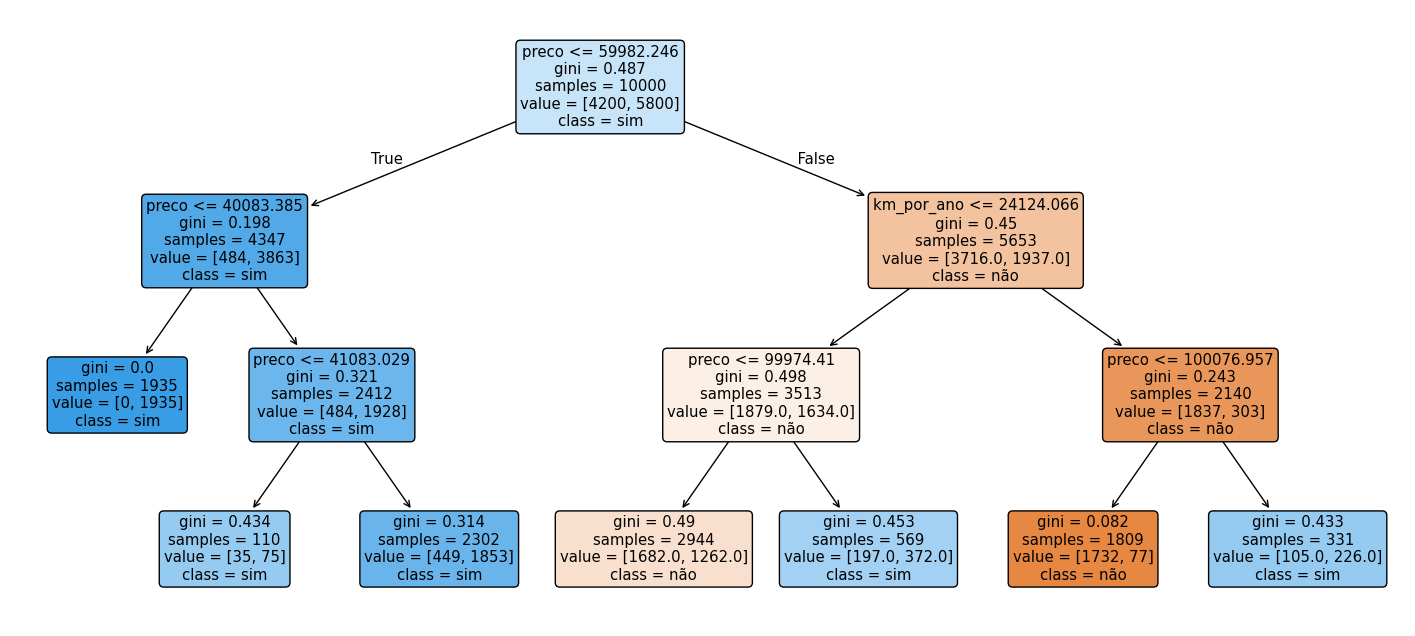

In [51]:
plt.figure(figsize=(18,8))
plot_tree(best_estimator,
          filled=True,
          rounded=True,
          feature_names=X.columns,
          class_names=['não', 'sim'])

### Busca de Hiperparâmetros e do **melhor modelo** com **RandomSearch**

Aleatoriamente o algoritmo escolhe pontos dentro do nosso espaço de parametros para adquirir os melhores hiperparâmetros, ao invés de realizar uma busca dentro do espaço inteiro de parametros.

**Diferenças**
- GridSearch
    - "Varre" todos os parametros (irá explorar exaustivamente todos os valores possíveis no espaço de hiperparâmetros)
    - Demora muito tempo
    - Paralelismo possível
    - Uma busca em Grid precisa de pontos específicos, ou seja, pontos discretos como 1,2,3 (números inteiros)
- RandomSearch
    - Busca aleatoriamente (não irá explorar exaustivamente todos os valores possíveis no espaço de hiperparâmetros)
    - Menos tempo
    - Paralelismo possível
    - Otimizações possíveis
    - Uma busca aleatória permite espaços contínuos, ou seja, números decimais.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Configurando o espaço de hiperparametros
parametros = {
    'max_depth': [3,5],
    'min_samples_split': [32,64,128],
    'min_samples_leaf': [32,64,128],
    'criterion': ['gini', 'entropy']
}

# Definindo qual será o modelo, no caso Árvore de Decisão
model_dt = DecisionTreeClassifier()

# Definindo o tipo da validação cruzada (no caso, KFold Estratificado)
cv = KFold(n_splits=10, shuffle=True)

# Algoritmo de busca de parametros
search = RandomizedSearchCV(model_dt, 
                            parametros, 
                            cv=cv,
                            random_state=SEED, # Necessário o número do seed para que a randomização seja a mesma para cada execução
                            n_jobs=-1, # Paraleliza o processo para todas as cores do processador
                            n_iter=16) # parâmetro que define a quantidade de iterações

# Treinar o algoritmo de busca (funciona como um modelo de ML)
search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=16, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5],
                                        'min_samples_leaf': [32, 64, 128],
                                        'min_samples_split': [32, 64, 128]},
                   random_state=42)

In [57]:
# Melhor hiperparâmetros
search.best_params_

{'min_samples_split': 128,
 'min_samples_leaf': 128,
 'max_depth': 3,
 'criterion': 'entropy'}

In [58]:
# Melhor estimador
search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=128,
                       min_samples_split=128)

**Validação aninhada (Nested Cross Validation) para o melhor modelo escolhido com RandomSearchCV**

In [60]:
scores = cross_val_score(search, X, y, cv=KFold(n_splits=10, shuffle=True))
imprime_score(scores)

Acurácia Médio: 78.68%
Intervalo: 76.64% // 80.72


### Customizando o espaço de hiper parâmetros

In [69]:
from scipy.stats import randint

# Configurando o espaço de hiperparametros
parametros = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': randint(32, 128), # Função para aleatorizar o número de samples e leaf
    'min_samples_leaf': randint(32, 128),
    'criterion': ['gini', 'entropy']
}

# Definindo qual será o modelo, no caso Árvore de Decisão
model_dt = DecisionTreeClassifier()

# Definindo o tipo da validação cruzada (no caso, KFold Estratificado)
cv = KFold(n_splits=10, shuffle=True)

# Algoritmo de busca de parametros
search = RandomizedSearchCV(model_dt, 
                            parametros, 
                            cv=cv,
                            random_state=SEED, # Necessário o número do seed para que a randomização seja a mesma para cada execução
                            n_jobs=-1, # Paraleliza o processo para todas as cores do processador
                            n_iter=16) # parâmetro que define a quantidade de iterações

# Treinar o algoritmo de busca
search.fit(X, y)

scores = cross_val_score(search, X, y, cv=KFold(n_splits=10, shuffle=True))
imprime_score(scores)

Acurácia Médio: 78.69%
Intervalo: 76.63% // 80.75


### Comparação entre **RandomSearchCV** e **GridSearchCV**

Utilizaremos agora uma floresta aleatória, diversas árvores serão treinadas para então, decidir a melhor árvore de decisão.

In [85]:
# Classe para automatizar o processo de validação cruzada e otimização de parâmetros
class Model_ML:
    def __init__(self, estimator, cv, params, X, y):
        self.estimator = estimator
        self.cv = cv
        self.params = params
        self.X = X
        self.y = y
        self.search = None

    def random_search(self):
        self.search = RandomizedSearchCV(self.estimator, 
                            self.params, 
                            cv=self.cv,
                            random_state=42,
                            n_jobs=-1,
                            n_iter=16)
    
    def grid_search(self):
        self.search = GridSearchCV(self.estimator,
                      self.params, 
                      cv=self.cv, 
                      n_jobs=-1)

    def training(self):
        self.search.fit(self.X, self.y)

    def cross_validation_score(self):
        scores = cross_val_score(self.search, self.X, self.y, cv=self.cv)
        imprime_score(scores)

In [92]:
from sklearn.ensemble import RandomForestClassifier
import time

# Seleção do algoritmo de ML e Validação Cruzada
model_rf = RandomForestClassifier()
cv = KFold(n_splits=10, shuffle=True)

# Configurações dos hiperparâmetros
# O parâmetro "bootstrap" define se irá pegar os mesmos dados para treino e validação cruzada (True), ou pegará dados aleatórios para cada uma das árvores (False)

params = {
    'n_estimators': [10,100], # Quantidade de árvores que serão criadas na floresta aleatória
    'max_depth': [3, 5],
    'bootstrap': [True, False],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy', 'logloss']
}

model = Model_ML(model_rf, cv, params, X, y)

tic = time.time()
model.random_search()
model.training()
tac = time.time()

print(f'Tempo de treinamento com RandomSearchCV: {tac - tic:.2f} segundos')

tic = time.time()
model.cross_validation_score()
tac = time.time()

print(f'Tempo de Validação Cruzada Aninhada com RandomSearchCV: {tac - tic:.2f} segundos')

# O PROCESSO ABAIXO DEMORA DEMAIS POR CONTA DO GRIDSEARCH

# model = Model_ML(model_rf, cv, params, X, y)

# tic = time.time()
# model.grid_search()
# model.training_and_view_scores()
# tac = time.time()

# print(f'Tempo de treinamento com GridSearchCV: {tac - tic:.2f} segundos')

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sk

Tempo de treinamento com RandomSearchCV: 7.62 segundos


c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sk

Acurácia Médio: 78.31%
Intervalo: 74.90% // 81.72
Tempo de Validação Cruzada Aninhada com RandomSearchCV: 63.89 segundos


In [90]:
# Melhores parametros
model.search.best_params_

{'n_estimators': 10,
 'min_samples_split': 32,
 'min_samples_leaf': 32,
 'max_depth': 5,
 'criterion': 'gini'}

In [91]:
# Melhor estimador
model.search.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=32, min_samples_split=32,
                       n_estimators=10)